In [ ]:
import pandas as pd
import requests
import re
API_KEY = ''
# Function to resolve the shortened URL
def resolve_shortened_url(short_url):
    try:
        # Send a GET request to the shortened URL
        response = requests.get(short_url, allow_redirects=True)
        return response.url
    except requests.RequestException as e:
        print(f"Error resolving shortened URL: {e}")
        return None

# Function to extract coordinates from the resolved URL
def extract_coordinates_from_url(url):
    # Regular expression to find the latitude and longitude in the URL
    match = re.search(r'@?([-]?\d{1,3}\.\d+),([-]?\d{1,3}\.\d+)', url)
    if match:
        latitude = float(match.group(1))
        longitude = float(match.group(2))
        return latitude, longitude
    else:
        return None, None
# path = "C:\Users\ASUS\OneDrive\Desktop\Cluster_information_route_unreached_clusters.xlsx"
# Example CSV file path (update as needed)
csv_file = r'C:\Users\ASUS\Downloads\Cluster_information_route_unreached_clusters.xlsx - Sheet2.csv'

# Read the CSV file
# df = pd.read_excel(csv_file, sheet_name='Sheet2')
df = pd.read_csv(csv_file)

# Check if the 'college location' column exists
# if 'Address' in df.columns:
#     # Loop through each URL in the 'college location' column
#     df['latitude'] = None
# df['longitude'] = None

# for index, address in enumerate(df['college location']):
#     resolved_url = resolve_shortened_url(address)
#     # print(f"Resolved URL: {resolved_url}")

#     if resolved_url:
#         lat, lng = extract_coordinates_from_url(resolved_url)
#         if lat is not None and lng is not None:
#             df.at[index, 'latitude'] = lat
#             df.at[index, 'longitude'] = lng
#         else:
#             print(f"No coordinates found for address: {address}")

# else:
#     print("Column 'college location' not found in the DataFrame.")

if 'Address' in df.columns:
    # Initialize latitude and longitude columns
    df['latitude'] = None
    df['longitude'] = None

    # Your Google Maps API key
    # API_KEY = 'YOUR_API_KEY'
    BASE_URL = 'https://maps.googleapis.com/maps/api/geocode/json'

    for index, address in enumerate(df['Address']):
        # Make a request to the Google Maps Geocoding API
        params = {
            'address': address,
            'key': API_KEY
        }
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        # Check if the response contains results
        if data['status'] == 'OK':
            # Extract latitude and longitude
            lat = data['results'][0]['geometry']['location']['lat']
            lng = data['results'][0]['geometry']['location']['lng']
            df.at[index, 'latitude'] = lat
            df.at[index, 'longitude'] = lng
            
            # Optionally, extract the formatted address
            formatted_address = data['results'][0]['formatted_address']
            df.at[index, 'formatted_address'] = formatted_address
            
            # Optionally, extract other components if needed
            components = data['results'][0]['address_components']
            for component in components:
                # You can store these components as needed; for example:
                if 'locality' in component['types']:
                    df.at[index, 'locality'] = component['long_name']
                elif 'administrative_area_level_1' in component['types']:
                    df.at[index, 'state'] = component['long_name']
                elif 'country' in component['types']:
                    df.at[index, 'country'] = component['long_name']

        else:
            print(f"No coordinates found for address: {address} - Status: {data['status']}")

else:
    print("Column 'college location' not found in the DataFrame.")


No coordinates found for address: nan - Status: ZERO_RESULTS
No coordinates found for address: nan - Status: ZERO_RESULTS


In [12]:
df = df.drop(columns=['Maps'])
df.head()


,College Name,Address,latitude,longitude,formatted_address,locality,state,country
0,Acharya Institute of Technology,"S. Radhakrishnan Road, Acharya P.O Soladevanah...",13.083937,77.4856,"Acharya Dr Sarvepalli Radhakrishnan Rd, Solade...",Soladevanahalli,Karnataka,India
1,Alliance College of Engineering & Design,"Central Campus, Anekal Main Rd, Chikkahagade C...",12.728214,77.68745,"Anekal Main Rd, Sidihosakote, Karnataka 562106...",Sidihosakote,Karnataka,India
2,Alpha College of Engineering,"30/2, Hennur Bagalur Main Rd, Sonam Layout, Vi...",13.075367,77.665245,"30/2, Hennur Bagalur Main Rd, Sonam Layout, Vi...",Bengaluru,Karnataka,India
3,AMC Engineering College,"Bannerghatta Main Rd, Kalkere, Bengaluru, Karn...",12.794368,77.620953,"Bannerghatta Rd, Karnataka, India",NaN,Karnataka,India
4,Amity University Bengaluru,"Road, NH-207, opposite to the office of Deputy...",12.991696,77.599694,"XHRX+MVG, HKP Road, Sulthangunta, Shivaji Naga...",Bengaluru,Karnataka,India


In [13]:

df.dropna(subset=['latitude', 'longitude'], inplace=True)



In [14]:
from scipy import stats

# Remove outliers in the 'latitude' and 'longitude' columns

# Calculate z-scores for 'latitude' and 'longitude'
z_scores = stats.zscore(df[['latitude', 'longitude']].astype(float))

# Filter out rows with z-scores greater than 3 or less than -3
df = df[(abs(z_scores) < 1).all(axis=1)]

In [15]:
df.shape


(40, 8)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


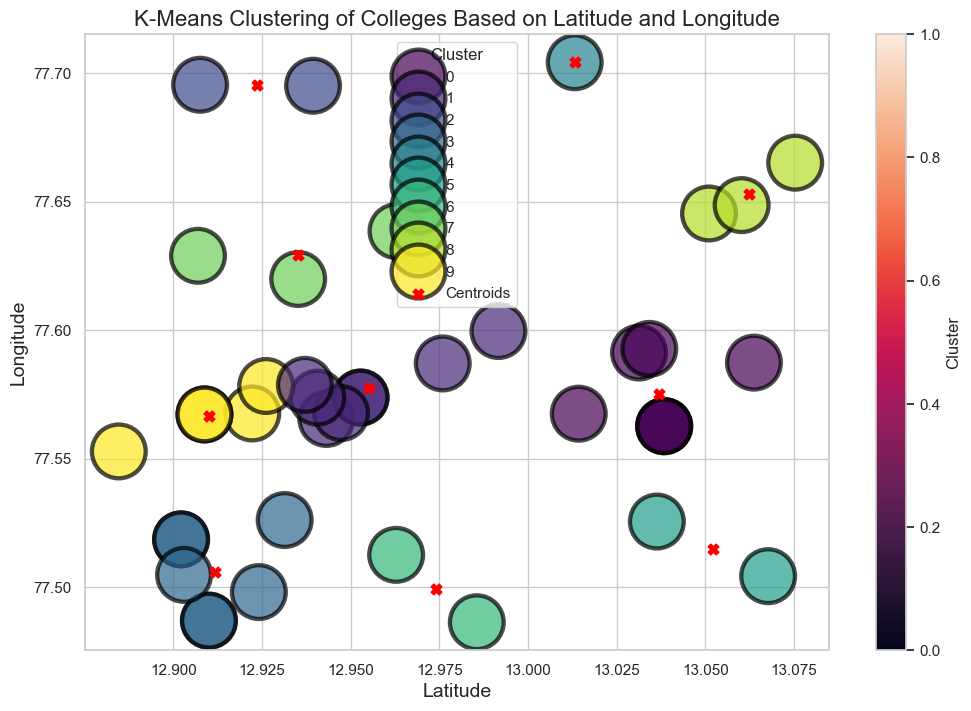

In [16]:
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Assuming df contains columns 'college name', 'latitude', 'longitude'
X = df[['latitude', 'longitude']].values

# KMeans clustering with 14 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Seaborn style for a better aesthetic
sns.set(style="whitegrid")

# Create a figure and axis for better customization
plt.figure(figsize=(12, 8))

# Scatter plot using Seaborn for enhanced visualization
sns.scatterplot(
    x='latitude', 
    y='longitude', 
    hue='Cluster', 
    palette='viridis', 
    data=df, 
    s=1500,  # Point size
    edgecolor='black', 
    alpha=0.7,  # Transparency
    legend='full'  # Full legend to display cluster colors
)

# Marking cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=60, marker='X', label='Centroids')

# Add title and labels
plt.title('K-Means Clustering of Colleges Based on Latitude and Longitude', fontsize=16)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)

# Add a legend for the clusters
plt.legend(title="Cluster", loc='best')

# Show plot with colorbar
plt.colorbar(label='Cluster')
plt.show()

# Print cluster assignments



In [17]:
df[['College Name', 'Address', 'Cluster']].sort_values('Cluster').groupby('Cluster').head(40)

,College Name,Address,Cluster
37,Ramaiah Institute of Technology,"MSR Nagar, Mathikere, Bangalore - 560054, Karn...",0
26,Indian Institute of Science (IISc),"CV Raman Road, Bangalore - 560012, Karnataka, ...",0
7,Atria Institute of Technology,"ASK Complex, Anand Nagar, Hebbal, Bengaluru, K...",0
25,Impact College of Engineering and Applied Scie...,"Kodigehalli, South, 60 Feet Rd, Sahakar Nagar,...",0
22,"Faculty of Engineering and Technology, M.S. Ra...","MSR Nagar, Mathikere, Bangalore - 560054, Karn...",0
53,Ramaiah Institute of Technology,"MSR Nagar, Mathikere, Bangalore - 560054, Karn...",0
38,RGC - Rajiv Gandhi Group of Institution,"Gundappa Reddy Layout, Chola Nagar, Cholanayak...",0
30,K.S. Group of Institutions,"145/4, Mount Joy Extension, Hanumanthnagar, Ba...",1
48,University Visvesvaraya College of Engineering...,"K. R. Circle, Bangalore - 560001, Karnataka, I...",1
55,Bangalore Institute of Technology,"K.R. Road, V.V. Puram, Bangalore - 560004, Kar...",1


In [19]:

import numpy as np
import itertools
from scipy.spatial.distance import pdist, squareform
start_coordinate = (12.93616, 77.60617)
def get_distance(api_key, origin, destination):
    """Get distance between two coordinates using Google Distance API."""
    url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin}&destinations={destination}&key={api_key}"
    
    response = requests.get(url)
    data = response.json()

    # Check if the response is valid
    if data['status'] == 'OK':
        return data['rows'][0]['elements'][0]['distance']['value']  # Return distance in meters
    else:
        print("Error in API response:", data['status'])
        return None




# Function to calculate the distance between two coordinates using the API
def get_distance_matrix(API_KEY, coordinates):
    """
    Get the distance matrix for all coordinates, including the start point.
    This function returns an NxN matrix, where each entry (i, j) is the distance
    from point i to point j.
    """
    n = len(coordinates)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            dist = get_distance(API_KEY, f"{coordinates[i][0]},{coordinates[i][1]}", 
                                         f"{coordinates[j][0]},{coordinates[j][1]}")
            if dist is not None:
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # symmetric matrix
            else:
                print(f"Failed to get distance between {coordinates[i]} and {coordinates[j]}.")
    
    return distance_matrix

# Function to solve the TSP using brute force (can be replaced by a more efficient algorithm)
def solve_tsp(distance_matrix):
    """
    Solves the Traveling Salesman Problem (TSP) using brute force.
    Returns the optimal route and the corresponding distance.
    """
    n = len(distance_matrix)
    all_permutations = itertools.permutations(range(1, n))  # Exclude the start point (0)
    
    min_route = None
    min_distance = float('inf')
    
    for perm in all_permutations:
        route = (0,) + perm + (0,)  # Start and end at the start point (0)
        distance = sum(distance_matrix[route[i], route[i+1]] for i in range(len(route)-1))
        
        if distance < min_distance:
            min_distance = distance
            min_route = route
            
    return min_route, min_distance



In [21]:
unique_clusters = df['Cluster'].unique()

# Create an empty dictionary to store the cluster dataframes
cluster_dfs = {}

# Loop through each unique cluster value and filter rows
for cluster in unique_clusters:
    cluster_dfs[f'Cluster_{cluster}'] = df[df['Cluster'] == cluster][['College Name', 'Address', 'latitude', 'longitude','formatted_address','locality']]

# # Optionally, print the clusters
# for cluster_name, cluster_df in cluster_dfs.items():
#     print(f"{cluster_name}:\n", cluster_df)

In [22]:
cluster_dfs['Cluster_2'].head()

,College Name,Address,latitude,longitude,formatted_address,locality
5,Amrita School of Engineering,"Kasavanahalli, Carmelaram PO, Sarjapur Rd, Ben...",12.907561,77.695579,"WM5W+26G, Gear School Rd, Doddakannelli, Benga...",Bengaluru
33,NHCE Bangalore - New Horizon College of Engine...,"2nd Block, Kadubeesanahalli, Marathahalli, Ban...",12.939414,77.695203,"Kadubeesanahalli, Bengaluru, Karnataka, India",Bengaluru


In [24]:
# cluster_dfs['Cluster_13'].head()
clusters_ =[cluster_dfs['Cluster_0'],cluster_dfs['Cluster_1'],cluster_dfs['Cluster_2'],cluster_dfs['Cluster_4'],cluster_dfs['Cluster_5'],cluster_dfs['Cluster_6'],cluster_dfs['Cluster_7'],cluster_dfs['Cluster_8'],cluster_dfs['Cluster_9']]

In [30]:
cluster_names_ = [f"cluster_{i}" for i in range(len(clusters_))] 

In [31]:

processed_clusters = []
for cluster_name, cluster in zip(cluster_names_, clusters_):
    print(f"Calculating optimal route for {cluster_name}...")
    
    # Extract destination coordinates from each cluster
    destination_coords = list(zip(cluster['latitude'], cluster['longitude']))

    # Add the starting point to the destination list
    coordinates = [start_coordinate] + destination_coords
    
    # Get the distance matrix for all points
    distance_matrix = get_distance_matrix(API_KEY, coordinates)

    # Solve the TSP to get the optimal route and the minimum distance
    optimal_route, total_distance = solve_tsp(distance_matrix)
    
    print(f"Optimal route for {cluster_name}: {optimal_route}")
    print(f"Total distance for {cluster_name}: {total_distance} km")
    
    # Prepare the optimized route
    # Exclude the starting point from the route for the DataFrame
    optimized_route = [optimal_route[i] for i in range(1, len(optimal_route)-1)]
    
    # Update the DataFrame with the visit order and total distance
    cluster['optimized_route'] = optimized_route  # Store the visit order (excluding start/end point)
    cluster['total_distance'] = total_distance/1000  # Set the total distance for all rows in the cluster
    cluster['Cluster_Tag'] = cluster_name  # Add a tag for the cluster
    
    # Append the modified cluster to the processed list
    processed_clusters.append(cluster)

# Concatenate all clusters into a single DataFrame
consolidated_df_ = pd.concat(processed_clusters, ignore_index=True)

# Display the consolidated DataFrame
print(consolidated_df_.head(2))

Calculating optimal route for cluster_0...
Optimal route for cluster_0: (0, 4, 5, 2, 7, 3, 1, 6, 0)
Total distance for cluster_0: 43810.0 km
Calculating optimal route for cluster_1...
Optimal route for cluster_1: (0, 1, 4, 5, 2, 6, 3, 7, 8, 0)
Total distance for cluster_1: 26392.0 km
Calculating optimal route for cluster_2...
Optimal route for cluster_2: (0, 1, 2, 0)
Total distance for cluster_2: 27797.0 km
Calculating optimal route for cluster_3...
Optimal route for cluster_3: (0, 1, 0)
Total distance for cluster_3: 36512.0 km
Calculating optimal route for cluster_4...
Optimal route for cluster_4: (0, 1, 2, 0)
Total distance for cluster_4: 47375.0 km
Calculating optimal route for cluster_5...
Optimal route for cluster_5: (0, 1, 2, 0)
Total distance for cluster_5: 47252.0 km
Calculating optimal route for cluster_6...
Optimal route for cluster_6: (0, 2, 1, 3, 0)
Total distance for cluster_6: 25304.0 km
Calculating optimal route for cluster_7...
Optimal route for cluster_7: (0, 2, 1, 3, 

In [28]:
consolidated_df_.groupby('Cluster_Tag').head(40)

,College Name,Address,latitude,longitude,formatted_address,locality,optimized_route,total_distance,Cluster_Tag
0,Atria Institute of Technology,"ASK Complex, Anand Nagar, Hebbal, Bengaluru, K...",13.031328,77.591313,"Anandnagar, Hebbal, Bengaluru, Karnataka 56002...",Bengaluru,4,43.810,cluster_1
1,"Faculty of Engineering and Technology, M.S. Ra...","MSR Nagar, Mathikere, Bangalore - 560054, Karn...",13.038421,77.562658,"M S R Nagar, Mathikere, Bengaluru, Karnataka 5...",Bengaluru,5,43.810,cluster_1
2,Impact College of Engineering and Applied Scie...,"Kodigehalli, South, 60 Feet Rd, Sahakar Nagar,...",13.063739,77.587393,"60 Feet Rd, Sahakar Nagar, Bengaluru, Karnatak...",Bengaluru,2,43.810,cluster_1
3,Indian Institute of Science (IISc),"CV Raman Road, Bangalore - 560012, Karnataka, ...",13.014334,77.567515,"CV Raman Rd, Bengaluru, Karnataka 560012, India",Bengaluru,7,43.810,cluster_1
4,Ramaiah Institute of Technology,"MSR Nagar, Mathikere, Bangalore - 560054, Karn...",13.038421,77.562658,"M S R Nagar, Mathikere, Bengaluru, Karnataka 5...",Bengaluru,3,43.810,cluster_1
5,RGC - Rajiv Gandhi Group of Institution,"Gundappa Reddy Layout, Chola Nagar, Cholanayak...",13.034224,77.592746,"Chola Nagar, Anandnagar, Hebbal, Bengaluru, Ka...",Bengaluru,1,43.810,cluster_1
6,Ramaiah Institute of Technology,"MSR Nagar, Mathikere, Bangalore - 560054, Karn...",13.038421,77.562658,"M S R Nagar, Mathikere, Bengaluru, Karnataka 5...",Bengaluru,6,43.810,cluster_1
7,Amity University Bengaluru,"Road, NH-207, opposite to the office of Deputy...",12.991696,77.599694,"XHRX+MVG, HKP Road, Sulthangunta, Shivaji Naga...",Bengaluru,4,26.522,cluster_2
8,Bangalore Institute of Technology,"K.R. Rd, V V Puram, Bengaluru, Karnataka 560004",12.952812,77.573809,"Krishna Rajendra Rd, Vishweshwarapura, Shankar...",Bengaluru,1,26.522,cluster_2
9,K.S. Group of Institutions,"145/4, Mount Joy Extension, Hanumanthnagar, Ba...",12.943151,77.565468,"145/4, Mount Joy Extension, Hanumanthnagar, Ba...",Bengaluru,2,26.522,cluster_2


In [32]:
consolidated_df_.to_excel('Engineering_unvisited_colleges_.xlsx', index=False)
